# Metadata

```
Course:  DS 5001
Module:  05
Topics:  Document Significant with `DFIDF`
```

# Exposition

* Three kinds of signficance:
  * __Local__: `TF-IDF` (significance of a term in a document; related to $p(w|d, C)$ ).
  * __Global__: Aggregate `TF-IDF` by term (significane of a term in the corpus; related to $p( w|C ) $ ).
  * __Document__: Aggreate `TF-IDF` by document (significance of document in the corpus; related to $p(d|W_d,C) $ ).
* `TF-IDF` is essentially local frequency balanced by global frequency.
* `DF-IDF` = `TF-IDF` Σ for boolean counts.
* `DF-IDF` is global boolean term entropy.
* Boolean counts are bad for computing local significance, but good for global.
* Max normalization is good for local significance.
* Doc significance should be computed from good local significance.

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'austen-melville'
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import plotly.graph_objects as go
import re

In [3]:
sns.set()

# Import Data

In [4]:
! ls {data_home}/output/{data_prefix}*

../data/output/austen-melville-BOW.csv
../data/output/austen-melville-CORPUS.csv
../data/output/austen-melville-CORPUS2.csv
../data/output/austen-melville-DTCM.csv
../data/output/austen-melville-LIB.csv
../data/output/austen-melville-SIGS.csv
../data/output/austen-melville-TFIDF.csv
../data/output/austen-melville-VOCAB.csv
../data/output/austen-melville-VOCAB2.csv
../data/output/austen-melville-WCM.csv


In [5]:
class aed(): pass

In [6]:
tables = dict(
    LIB = dict(index=OHCO[:1]),
    VOCAB2 = dict(index='term_str'),
    CORPUS2 = dict(index=OHCO)
)

In [7]:
for table in tables:
    setattr(aed, table, pd.read_csv(f"{data_home}/output/{data_prefix}-{table}.csv").set_index(tables[table]['index']))

# TFIDIF 

## Create BOW

In [140]:
# bag = OHCO[:2]
bag = OHCO[:3]

In [141]:
BOW = aed.CORPUS2.groupby(bag+['term_str']).term_str.count().to_frame('n')

In [142]:
DTM = BOW.unstack()
DTM.columns = DTM.columns.droplevel(0)

In [143]:
DTM

term_str                   0    1  10  100  1000  10000  10440  10800  10th  \
book_id chap_id para_num                                                      
105     1       1        NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                2        NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                3        NaN  2.0 NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                4        NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                5        NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
...                       ..  ...  ..  ...   ...    ...    ...    ...   ...   
34970   114     18       NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                19       NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                20       NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                21       NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   
                24       NaN  NaN NaN  NaN   NaN    NaN    NaN    NaN   NaN   

term_str                  118952  ...  zoroaster  zozo  zuma  zur   à  æneas  \
book_id chap_id para_num          ...                                          
105     1       1            NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                2            NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                3            NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                4            NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                5            NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
...                          ...  ...        ...   ...   ...  ...  ..    ...   
34970   114     18           NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                19           NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                20           NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                21           NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   
                24           NaN  ...        NaN   NaN   NaN  NaN NaN    NaN   

term_str                  æniad  æson  æsops  ł20000  
book_id chap_id para_num                              
105     1       1           NaN   NaN    NaN     NaN  
                2           NaN   NaN    NaN     NaN  
                3           NaN   NaN    NaN     NaN  
                4           NaN   NaN    NaN     NaN  
                5           NaN   NaN    NaN     NaN  
...                         ...   ...    ...     ...  
34970   114     18          NaN   NaN    NaN     NaN  
                19          NaN   NaN    NaN     NaN  
                20          NaN   NaN    NaN     NaN  
                21          NaN   NaN    NaN     NaN  
                24          NaN   NaN    NaN     NaN  

[29362 rows x 39424 columns]

In [282]:
books = {}
for book_id in aed.LIB.index:
    
    # Get book
    book = DTM.loc[book_id]
    print(book_id, aed.LIB.loc[book_id].title)
    
    # TFIDF, etc.
    tp = (book.T / book.T.sum()).T
    dp = book.count() / len(book)
    idp = np.log2(1/dp)
    tpidp = tp * idp
    dpidp = dp * idp
    
    # Experimental metric
    a = book / book.sum()
    test = a * np.log2(1/a)
    
    # Aggregates
    M = tpidp.stack()
    agg = M.groupby('chap_id').sum().to_frame('tpidp_sum')
    agg['tpidp_mean'] = M.groupby('chap_id').mean()
    agg['tpidp_max'] = M.groupby('chap_id').max()
    agg['n_tokens'] = book.sum(1).groupby('chap_id').sum()
    
    # Bundle
    books[book_id] = {
        'tpidp': tpidp.stack(),
        'dpidp': dpidp,
        'test': test,
        'agg': agg
    }

105 PERSUASION
121 NORTHANGER ABBEY
141 MANSFIELD PARK
158 EMMA
161 SENSE AND SENSIBILITY
946 LADY SUSAN
1212 LOVE AND FREINDSHIP SIC
1342 PRIDE AND PREJUDICE
1900 TYPEE A ROMANCE OF THE SOUTH SEAS
2701 MOBY DICK OR THE WHALE
4045 OMOO ADVENTURES IN THE SOUTH SEAS
8118 REDBURN HIS FIRST VOYAGE BEING THE SAILOR BOY CONFESSIONS AND REMINISCENCES OF THE SON OF A GENTLEMAN IN THE MERCHANT NAVY
10712 WHITE JACKET OR THE WORLD ON A MAN OF WAR
13720 MARDI AND A VOYAGE THITHER VOL I
13721 MARDI AND A VOYAGE THITHER VOL II
15422 ISRAEL POTTER HIS FIFTY YEARS OF EXILE
21816 THE CONFIDENCE MAN HIS MASQUERADE
34970 PIERRE OR THE AMBIGUITIES


In [297]:
def plot_sig_docs(book_id, m='tpidp_mean'):
    global books
    BOOK = books[book_id]
    book_title = aed.LIB.loc[book_id].title
    return px.scatter(
        BOOK['agg'].reset_index(),
        x='chap_id', y=m, 
        text='chap_id', size='n_tokens', color='tpidp_max',
        title=f"{book_title} ({m.replace('_', ' ')})", 
        height=500
    )

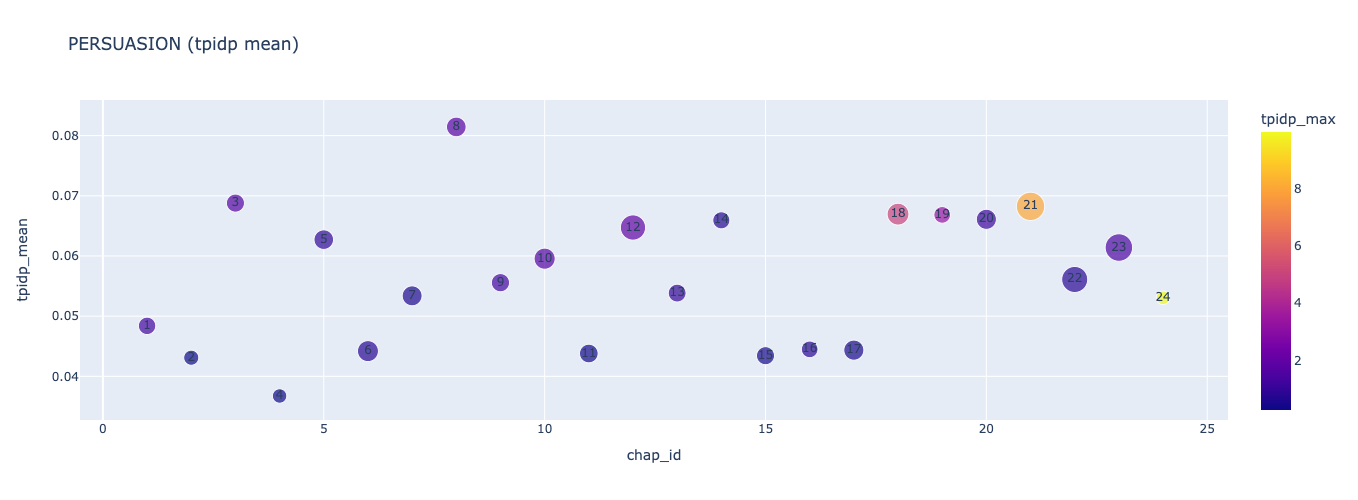

In [298]:
plot_sig_docs(105)

> **Chapter 8** Captain Wentworth and Anne Elliot are now in the same social circle and must repeatedly dine together. They refrain from having any conversation, however, except what politeness necessitates. Anne thinks about how their temperaments are perfectly suited to each other. She thinks that Admiral and Mrs. Croft are the only couple she knows that could be nearly as attached and happy as she and Captain Wentworth once had the chance of being. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The dinner conversation turns to the Navy and to Captain Wentworth's experiences on the ships. Mrs. Musgrove implores him to tell her what he knows of her late son, Dick Musgrove, who served beneath him on the Laconia. Captain Wentworth moves to sit next to Mrs. Musgrove and talk to her, comfortingly, about her son<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Captain Wentworth is sensitive in dealing with Mrs. Musgrove, amusing at dinner, and outspoken in his beliefs. He admits that he would never willingly let women aboard his ship, as he thinks it is not a suitable place for them. Mrs. Croft disagrees, and asserts her feeling that she has always been perfectly comfortable on board her husband's ship. The Crofts joke that when Frederick Wentworth is married, he will sing a different tune. The Crofts discuss their marriage. Mrs. Croft travels with her husband almost everywhere and cannot bear to be separated from him.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;At the end of the evening there is dancing, and Anne prefers to play music for them all night. Captain Wentworth seems to be having a terrific time. All the young ladies, including both Miss Musgroves are enamored by him. Although he rarely addresses her, Anne is hurt by the "cold politeness" in his voice.


> **Chapter 12 signals a climax in the novel's narrative.** Persuasion is a linear narrative that is organized chronologically. The original edition of this novel was published in two volumes, the first volume ending at the close of Chapter 12. Louisa's fall is the greatest dramatic occurrence which has happened so far. By inserting the fall here, Austen creates a cliffhanger and encourages her readers to buy the second volume of her novel. In these chapters, the reader is shown the negative effects of what can happen when one is too stubborn. Louisa would not be persuaded to keep from jumping off the wall. Her firmness of mind means serious injury for her and significant guilt for Captain Wentworth. He is encouraged to rethink his initial judgment of the benefit of a "strong character." https://www.sparknotes.com/lit/persuasion/section6/page/2

> **Chapter 21 is the big reveal.** Mrs. Smith tells Anne the story of her acquaintance with Mr. Elliot. She considers him to be a man "without a heart or a conscience…a cold-blooded being." In the past, he had been the good friend of her late husband, and Mrs. Smith had accepted him as a friend of her own. They had often assisted him when he was having financial trouble. Mr. Elliot married entirely for money, dismissing the honor of marriage to Elizabeth in favor of wealth and independence. Mrs. Smith often heard him say that if he could sell his baronetcy, anyone could have it for fifty pounds. She shows Anne a letter written by Mr. Elliot in which he promises to destroy Kellynch or sell it for as much money as he can get. After his marriage to a wealthy, but untitled woman, he encouraged Mr. Smith to live extravagantly and go into great debt. He brought the Smiths to financial ruin and refused to help them. Upon Mr. Smith's death, Mr. Elliot, the executor of his will, refused to act, thereby leaving all 
the debts and difficulties onto his grieving widow. https://www.sparknotes.com/lit/persuasion/section11

In [137]:
pg105_chaps = """
Volume I
    Chapter I [1] ~ The history of the Elliots and their financial status
    Chapter II [2] ~ Mr. Shepherd suggests that Sir Walter remove to Bath
    Chapter III [3] ~ A tenant is found for Kellynch Hall
    Chapter IV [4] ~ Anne remembers the summer of the Year Six
    Chapter V [5] ~ The Elliots depart for Bath, and Anne goes to Uppercross
    Chapter VI [6] ~ The Crofts take possession; Meet the Musgroves; the tale of Poor Dick
    Chapter VII [7] ~ Captain Wentworth arrives at Kellynch; young Charles Musgrove has a fall; Captain Wentworth visits the Cottage
    Chapter VIII [8] ~ Captain Wentworth goes to a dinner party at the Great House
    Chapter IX [9] ~ Charles Hayter is jealous; Captain Wentworth helps Anne with the Musgrove children
    Chapter X [10] ~ The Long Walk to Winthrop
    Chapter XI [11] ~ The trip to Lyme Regis; Anne comforts Captain Benwick
    Chapter XII [12] ~ Mr. Elliot is seen in Lyme; Louisa has an accident
VolumeII
    Chapter I [13] ~ Waiting at Uppercross and Kellynch Lodge for word of Louisa; Admiral Croft discusses his improvements at Kellynch
    Chapter II [14] ~ Charles and Mary return to Uppercross; the Musgroves return for Christmas; Anne and Lady Russell remove to Bath
    Chapter III [15] ~ Sir Walter and Elizabeth are very happy in Bath and have many acquaintances; Anne meets Mr. Elliot once again
    Chapter IV [16] ~ Our Cousins, The Dalrymples; a discussion of good company vs. the best
    Chapter V [17] ~ Anne calls on Mrs. Smith, to Sir Walter's disgust; Lady Russell reveals her dearest wish to Anne
    Chapter VI [18] ~ A letter from Mary; Anne meets Admiral Croft
    Chapter VII [19] ~ Anne sees Captain Wentworth; later, they meet
    Chapter VIII [20] ~ The concert
    Chapter IX [21] ~ Anne and Mrs. Smith discuss Mr. Elliot
    Chapter X [22] ~ Charles and Mary come to Bath; Miss Elliot plans a party; Anne sees Mr. Elliot speaking to Mrs. Clay
    Chapter XI [23] ~ Anne has a conversation with Captain Harville at the White Hart; The Letter
    Chapter XII [24] ~ Who can be in doubt of what followed?
    The "Cancelled Chapters" ~ The ending as Jane Austen originally wrote it, and later changed.
""".split("\n")[1:-1]

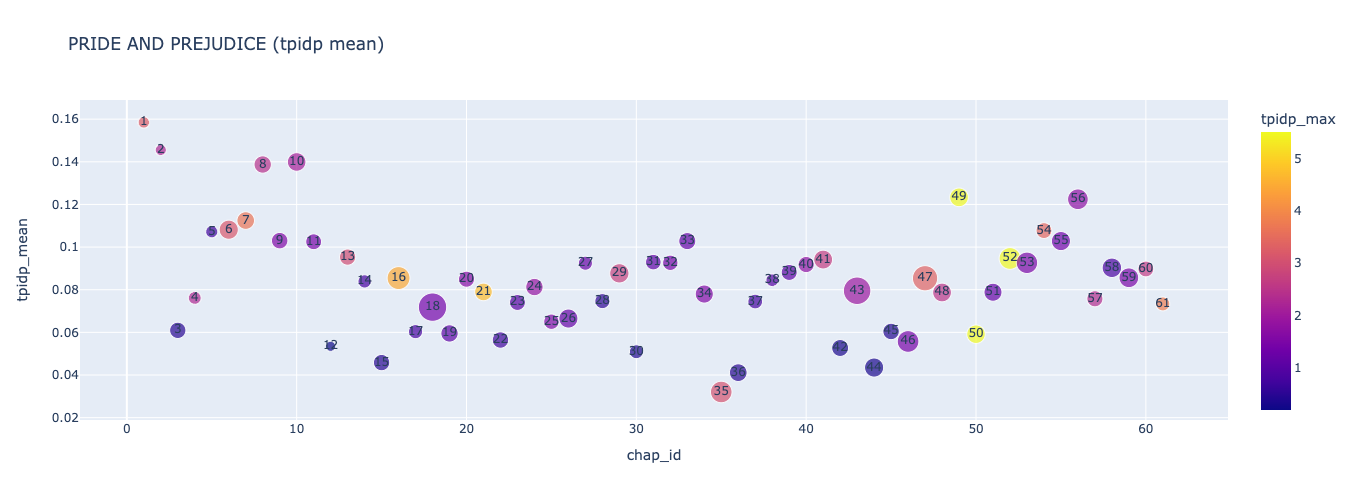

In [302]:
plot_sig_docs(1342)

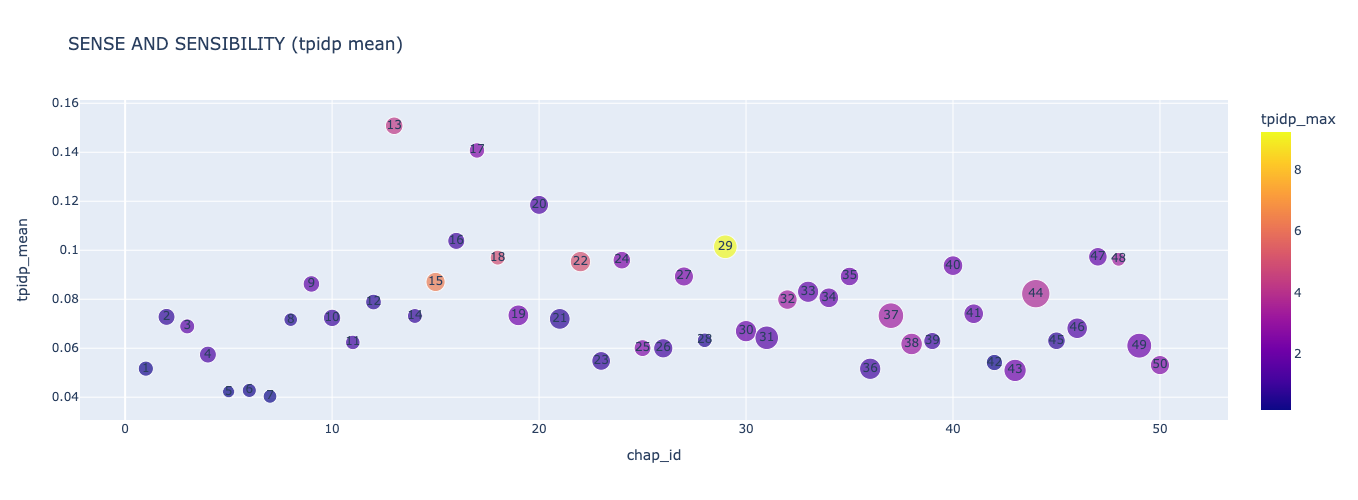

In [303]:
plot_sig_docs(161)

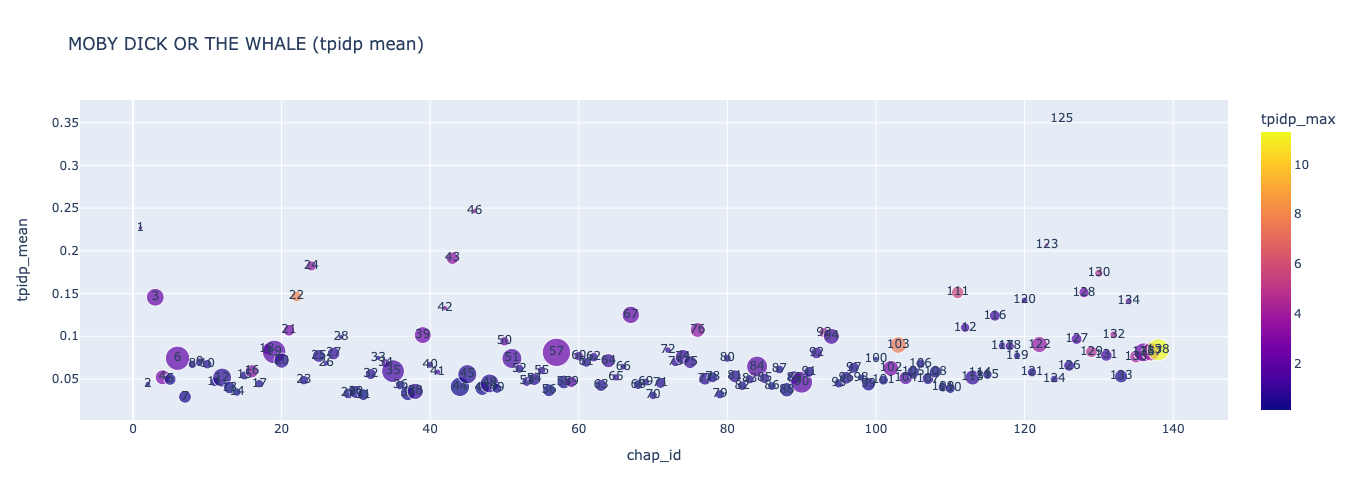

In [304]:
plot_sig_docs(2701)

# Explore Mean Bag Size

In [328]:
X = DTM.sum(1)

In [329]:
PARA_mean = X.groupby(OHCO[:2]).agg('mean')

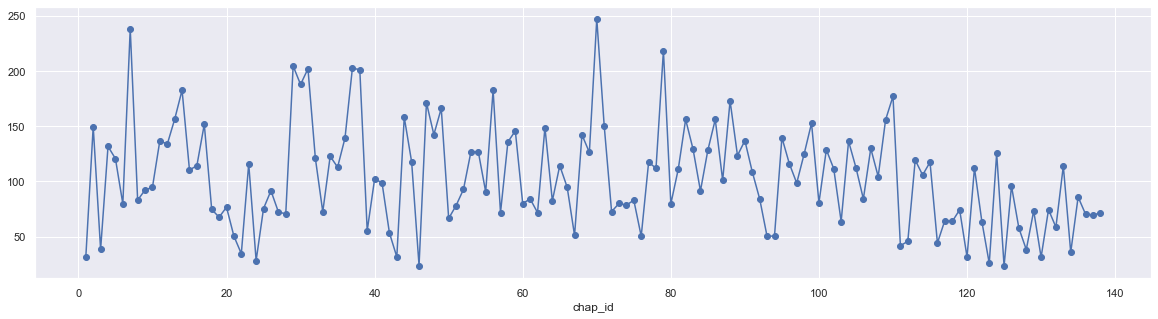

In [330]:
PARA_mean[2701].plot(figsize=(20,5), style='o-');